## Tasks
Collaborator | email
:---|:---
Perez, Marcelo | marcelo.perez@yale.edu
Alarcon, Claudio | claudio.alarcon@yale.edu

- [ ] Use `STAR` to align `gencode.v34` genome to the meRIP-seq data 
- [ ] Use `RADAR` to do differential analysis of m6A peaks
- [ ] Run `guitar`
- [ ] Use `FIRE` to do `DRACH` & `RGAC` motif enrichment analysis 

# Alignment task - Running `STAR`

In [1]:
cat ~/GitHub/imRIP/scripts/star.sh

PDIR=$1
JOBS=$2

cd $PDIR
mkdir -p bam
mkdir -p logs/star_aligner

INDEX='/rumi/shams/abe/genomes/hg38/gencode.v34/star_index'

STAR --genomeLoad LoadAndExit --genomeDir $INDEX
for fq in fastq/*R1*fastq.gz; do
    fq1=`basename $fq`
    fq2=${fq1/_R1_/_R2_}
    out=${fq1/_R1_001.fastq.gz/}
    echo '--------------' $out '--------------'
    STAR \
    --outSAMtype BAM SortedByCoordinate \
    --readFilesCommand zcat \
    --runThreadN $JOBS \
    --genomeDir $INDEX \
    --readFilesIn fastq/$fq1 fastq/$fq2 \
    --outFileNamePrefix bam/$out \
    --outReadsUnmapped Fastx;

    mv -v bam/${out}Aligned.sortedByCoord.out.bam bam/${out}.bam
    mv -v bam/${out}Log.final.out logs/star_aligner/
    rm -v bam/${out}*out*
done

STAR --genomeLoad Remove --genomeDir $INDEX

rm -r _STARtmp/ Log.out Log.progress.out Aligned.out.sam


# Peak calling task - Running `RADAR`

https://scottzijiezhang.github.io/RADARmanual/workflow.html

In [4]:
%reload_ext rpy2.ipython

In [5]:
%%R 
suppressMessages(suppressWarnings(library (RADAR)))

GTF = '/rumi/shams/abe/genomes/hg38/gencode.v34/gencode.v34.annotation.gtf'

### 1. load `bam` files and make `MeRIP.RADAR` object
I'll save the object for later usage while it takes long time to generate. 

In [2]:
import os
from glob import glob 

Rename `fastq` files

Rename `bam` files

### _Nuc 15' vs. Nuc 0'_

In [37]:
%%R 
radar <- countReads(
	samplenames=c('N-EGF0-1','N-EGF0-2','N-EGF0-3','N-EGF15-1','N-EGF15-2','N-EGF15-3'), gtf = GTF,
	bamFolder='./bam/',modification = "m6A", 
    strandToKeep = "opposite",
    outputDir='radar', 
    threads = 18
) 

[1] "Stage: index bam file ./bam//N-EGF0-1.input.bam"
[1] "Stage: index bam file ./bam//N-EGF0-1.m6A.bam"
[1] "Stage: index bam file ./bam//N-EGF0-2.input.bam"
[1] "Stage: index bam file ./bam//N-EGF0-3.input.bam"
[1] "Stage: index bam file ./bam//N-EGF0-3.m6A.bam"
[1] "Stage: index bam file ./bam//N-EGF15-1.input.bam"
[1] "Stage: index bam file ./bam//N-EGF15-1.m6A.bam"
[1] "Stage: index bam file ./bam//N-EGF15-2.input.bam"
[1] "Stage: index bam file ./bam//N-EGF15-2.m6A.bam"
[1] "Stage: index bam file ./bam//N-EGF15-3.input.bam"
[1] "Stage: index bam file ./bam//N-EGF15-3.m6A.bam"
Reading gtf file to obtain gene model
Filter out ambiguous model...


R[write to console]: Import genomic features from the file as a GRanges object ... 
R[write to console]: OK

R[write to console]: Prepare the 'metadata' data frame ... 
R[write to console]: OK

R[write to console]: Make the TxDb object ... 
R[write to console]: OK



Gene model obtained from gtf file...
counting reads for each genes, this step may takes a few hours....
Hyper-thread registered: TRUE 
Using 18 thread(s) to count reads in continuous bins...
Time used to count reads: 68.0863045970599 mins... 


In [67]:
!mkdir -p radar

In [68]:
%%R 
saveRDS(radar, 'radar/N-EGF15vs0-raw-Obj.rds')

In [39]:
%%R 
summary(radar)

MeRIP dataset of 6 samples.
Read count quantified in 50-bp consecutive bins on the transcript.
The total read count for Input and IP samples are (Million reads):
      N-EGF0-1 N-EGF0-2 N-EGF0-3 N-EGF15-1 N-EGF15-2 N-EGF15-3
Input    18.42    15.44     1.76      5.56     11.86     29.73
IP        4.36     9.26     8.74     10.05     10.41     10.05


___

### 2. Running RADAR pre processing commands 
https://scottzijiezhang.github.io/RADARmanual/Mannual.html

Proceesed data will be saved as `radar/*-processed-Obj.rds`

In [1]:
%reload_ext rpy2.ipython

In [2]:
%%R 
suppressMessages(suppressWarnings(library (RADAR)))

In [3]:
%%R 
radar0 <- readRDS('radar/N-EGF15vs0-raw-Obj.rds')
radar0 <- normalizeLibrary(radar0, boxPlot=0)

In [4]:
%%R 
radar0 <- adjustExprLevel(radar0)
# radar <- adjustExprLevel(radar, adjustBy = "pos")

# If you expect intensive alternative splicing events cross the experimental groups, 
# using gene-level read counts to represent pre-IP RNA level could leads to bias. 
# Therefore, the user can also choose to use the local bin-level read count to adjust 
# the pre-IP RNA level variation

variable(radar0) <- data.frame( group = c(rep("time-0",3),rep("time-15",3)))

Adjusting expression level using Input geneSum read count...


In [5]:
%%R
radar0 <- filterBins(radar0,minCountsCutOff = 15)

radar0 <- diffIP_parallel(radar0,thread = 18)
saveRDS(radar0, 'radar/N-EGF15vs0-processed-Obj.rds')

Filtering bins with low read counts...
Bins with average counts lower than  15  in both groups have been removed...
Filtering bins that is enriched in IP experiment...The predictor variable has been converted:
 time-0  time-0  time-0 time-15 time-15 time-15 
      0       0       0       1       1       1 
running PoissonGamma test at single beta mode
Hyper-thread registered: TRUE 
Using 18 thread(s) to run PoissonGamma test...
Time used to run PoissonGamma test: 0.70255982875824 mins... 



### 4. Get results and select significant bins

Results for all data (no filtering):

In [3]:
%%R 
radar0 <- readRDS('radar/N-EGF15vs0-processed-Obj.rds')

radar_all <- reportResult(radar0, cutoff = 1.1, Beta_cutoff = 0.00, threads=18)

result_all <- results(radar_all)
rm(radar0)

Hyper-thread registered: TRUE 
Using 18 thread(s) to report merged report...
Time used to report peaks: 3.36799996693929 mins... 
When merging neighboring significant bins, logFC was reported as the max logFC among these bins.
p-value of these bins were combined by Fisher's method.
There are 29619 reported differential loci at FDR < 1.1 and logFoldChange > 0.


In [4]:
%%R 
saveRDS(result_all, 'radar/N-EGF15vs0-result_all-Obj.rds')

> Due to the resolution of the MeRIP-seq experiment where RNA molecules are fragmented into 100-300nt, neighboring bins can usually contain reads from the same locus. Therefore, we do a post-processing to merge significant neighboring bins after the test to obtain a final list of differential peaks. We merge the p-value of connecting bins by fisher’s method and report the max beta from neighbouring bins.

Here, we use FDR<0.1 and log fold change > 0.5 as default cutoff for selecting significant bins

In [6]:
%%R 
radar0 <- readRDS('radar/N-EGF15vs0-processed-Obj.rds')

radar_sig <- reportResult(radar0, cutoff = 0.10, Beta_cutoff = 0.5) #, threads=18)

result_sig = results(radar_sig) 
rm(radar0)

Hyper-thread registered: TRUE 
Using 1 thread(s) to report merged report...
Time used to report peaks: 1.84041694800059 mins... 
When merging neighboring significant bins, logFC was reported as the max logFC among these bins.
p-value of these bins were combined by Fisher's method.
There are 1664 reported differential loci at FDR < 0.1 and logFoldChange > 0.5.


In [7]:
%%R 
saveRDS(result_sig, 'radar/N-EGF15vs0-result_sig-Obj.rds')

### 5. Pre processing plots

Below command normalize the library and make box plots. I'll save the plots into files.

In [7]:
!mkdir -pv plots

In [8]:
%%R
## save pictures 
radar0 <- readRDS('radar/N-EGF15vs0-processed-Obj.rds')

pdf('plots/boxPlot.pdf')
radar <- normalizeLibrary(radar0)
dev.off()
png('plots/boxPlot.png')
radar <- normalizeLibrary(radar0)
dev.off()

png 
  2 


In [12]:
%%R 
pdf('plots/HeatMap.pdf')
plotHeatMap(radar_sig)
dev.off()
png('plots/HeatMap.png')
plotHeatMap(radar_sig)
dev.off()

Plot heat map for differential loci at FDR < 0.1 and logFoldChange > 0.5.
Returning normalized and expression level adjusted IP read counts.
Plot heat map for differential loci at FDR < 0.1 and logFoldChange > 0.5.
Returning normalized and expression level adjusted IP read counts.
png 
  2 


Plot heat map for differential loci at FDR < 0.1 and logFoldChange > 0.5.
Returning normalized and expression level adjusted IP read counts.


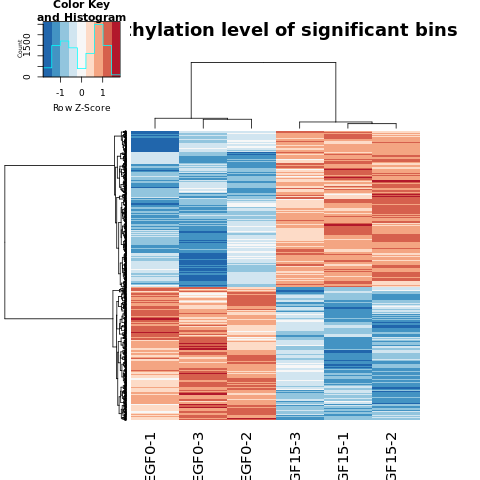

In [13]:
%%R 
plotHeatMap(radar_sig)

There are 1664 reported differential loci at FDR < 0.1 and logFoldChange > 0.5.


R[write to console]: Import genomic features from the file as a GRanges object ... 
R[write to console]: OK

R[write to console]: Prepare the 'metadata' data frame ... 
R[write to console]: OK

R[write to console]: Make the TxDb object ... 
R[write to console]: OK



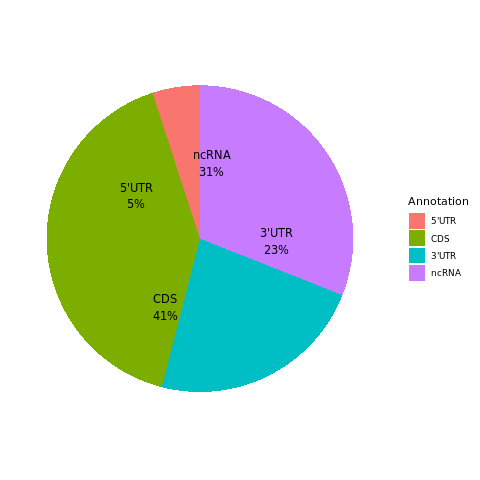

In [25]:
%%R 
p <- peakDistribution(radar_sig)

png('plots/peakDistribution.png')
print (p)
dev.off()
pdf('plots/peakDistribution.pdf')
print (p)
dev.off()
p

### 5. PCA analysis

Returning normalized IP read counts.
Returning normalized IP read counts.


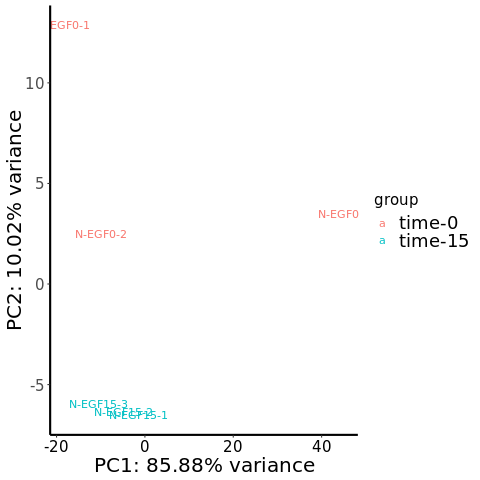

In [24]:
%%R 
# radar0 <- readRDS('radar/finalObj.rds')

top_bins <- extractIP(radar0,filtered = T)[order(rowMeans( extractIP(radar0,filtered = T) ),decreasing = T)[1:1000],] 
## save pictures 
p <- plotPCAfromMatrix(top_bins,group = unlist(variable(radar0)) )
png('plots/PCAPlot.png')
print (p)
dev.off()
pdf('plots/PCAPlot.pdf')
print (p)
dev.off()
p

In [ ]:
%%R 
rm (result_all)
rm (result_sig)

### 4. Save results into files

In [2]:
%reload_ext rpy2.ipython

In [3]:
%%R 
suppressMessages(suppressWarnings(library (RADAR)))
suppressMessages(suppressWarnings(library (tidyverse)))

In [4]:
%%R 
GTF = '/rumi/shams/abe/genomes/hg38/gencode.v34/gencode.v34.annotation.gtf'

gtf <- rtracklayer::import(GTF)

gene2name <- gtf[gtf$type == "gene"] %>% data.frame %>% column_to_rownames('gene_id') %>% dplyr::select('gene_name')
message ('-> GTF loaded!')

add_Name <- function(res, gene2name){
    res$ensembl <- res$name %>% as.character
    res$name <- gene2name[res$ensembl %>% as.character,]
    return (res)
}

R[write to console]: -> GTF loaded!



In [5]:
%%R 
result_all <- readRDS('radar/N-EGF15vs0-result_all-Obj.rds')
result_sig <- readRDS('radar/N-EGF15vs0-result_sig-Obj.rds')

write.table(add_Name(result_all, gene2name), file = "radar/N-EGF15vs0-result-all.txt",row.names=F, sep='\t', quote=FALSE) 
write.table(add_Name(result_sig, gene2name), file = "radar/N-EGF15vs0-result-sig.txt",row.names=F, sep='\t',quote=FALSE) 

#### Save results into `bed12` format 
`tidyverse` can not be loaded while using RADAR!

In [13]:
%%R
# save bed 12 format 
names(result_all)[1] <- paste0("# ", names(result_all)[1])
write.table(result_all %>% dplyr::select(c(1:12)), file = "radar/N-EGF15vs0-result-all.bed",row.names=F, sep="\t", quote=FALSE) 

In [14]:
%%R 
# save bed 12 format 
names(result_sig)[1] <- paste0("# ", names(result_sig)[1])
write.table(result_sig %>% dplyr::select(c(1:12)), file = "radar/N-EGF15vs0-result-sig.bed",row.names=F, sep='\t',quote=FALSE)

#### Exrtact results for running iGET 

In [15]:
%%R 
iPAGE_input = result_sig %>%
    mutate(ensembl=result_sig$name %>% substr(0, 15)) %>% 
    dplyr::select('ensembl', 'logFC')

write.table(iPAGE_input, file = 'radar/N-EGF15vs0.txt', sep='\t',col.names = F, row.names=F, quote=FALSE)

___

### 8. Draw volcano plot and test global methylation shift 

In [16]:
%%R 
library (ggrepel)
library (patchwork)

plot_Save <- function (p, name_it){
    ggsave(paste(name_it,'png',sep='.'), plot = p, device = 'png', dpi = 300)
    ggsave(paste(name_it,'pdf',sep='.'), plot = p, device = 'pdf', dpi = 300)
}


plot_Hist = function(res, title, x_min=-10,x_max=10){
    w <- wilcox.test(res$logFC, mu=0, alternative = "greater")
    t <- t.test(res$logFC, mu=0, alternative = "greater")
    h = ggplot(res, aes(x=logFC)) + 
        ggtitle(title,sprintf(
            "wilcox.test (-log10 p.value): %.5f \nt.test (-log10 p.value):%.5f \n[mu=0,alter=greater]", 
            -log10(w$p.value), -log10(t$p.value))) +
        theme_bw() + 
        xlim(c(x_min,x_max)) +
        geom_histogram(binwidth=0.1)

    return (h)
} 

plot_Volcano <- function(res, title='', 
                         lfc.cutoff  = 1, pval.cutoff = 0.05,
                         x_min=-10,x_max=10){
    res$sig <- as.factor(res$p_value < pval.cutoff & abs(res$logFC) > lfc.cutoff)
    relevel(res$sig, ref=TRUE)

    vol = res %>% ggplot(
        aes(x=logFC, y=-log10(p_value), colour=sig, fill=sig)) +
        geom_point(aes(color = sig),alpha = 1/10) +
            xlim(c(x_min,x_max)) +
#             ylim(c(2,15)) +
            geom_hline(yintercept=-log10(pval.cutoff), linetype="dashed", alpha = 4/10) +
            geom_vline(xintercept=lfc.cutoff, linetype="dashed", alpha = 4/10) +
            geom_vline(xintercept=(-1)*lfc.cutoff, linetype="dashed", alpha = 4/10) +
            scale_color_manual(values = c("grey", "red")) +
            theme_bw() + 
            theme(legend.position="none") +
            ggtitle (title) #+ 
#             geom_text_repel(
#                 data = subset(res[order(res$p_value),], sig == TRUE)[1:7,],
#                 aes(label = name),
#                 size = 3,
#                 box.padding = unit(0.35, "lines"),
#                 point.padding = unit(0.3, "lines")
#             )
     return (vol)
} 

Volcano plot and histogram 

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image



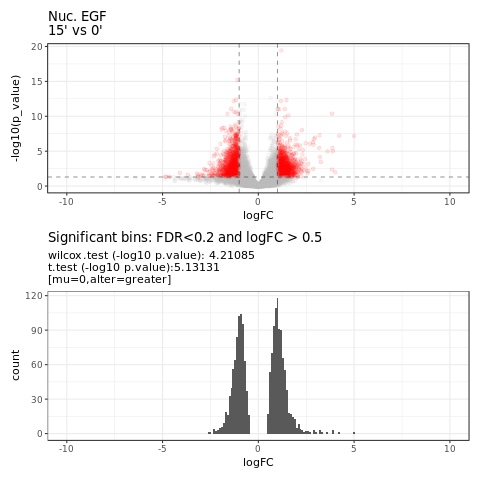

In [17]:
%%R 
res = read.table('radar/N-EGF15vs0-result-all.txt', header=TRUE,stringsAsFactors=FALSE)
res_sig = read.table('radar/N-EGF15vs0-result-sig.txt', header=TRUE,stringsAsFactors=FALSE)

vol = plot_Volcano (res, "Nuc. EGF\n15' vs 0'")
his2 = plot_Hist(res_sig, 'Significant bins: FDR<0.2 and logFC > 0.5')


plot_Save(vol / his2, 'plots/Volcano')
vol / his2

___
### 9. Check logFC direction for top hits 

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R 
suppressMessages(suppressWarnings(library (RADAR)))
suppressMessages(suppressWarnings(library (tidyverse)))

In [ ]:
%%R
radar0 <- readRDS('radar/finalObj.rds')

In [ ]:
%%R 
sizeFactors(radar0)

In [ ]:
%%R 
IP = extractIP(radar0, normalized=T, adjusted=T, filtered=T)

In [ ]:
%%R 
Input = extractInput(radar0, normalized=T)

In [ ]:
%%R 
rm(radar0)

Results sorted by logFC and p-value:

In [ ]:
%%R 
res_sig = read.table('radar/result.sig.txt', header=TRUE,stringsAsFactors=FALSE)

data <- res_sig %>% data.frame %>% dplyr::select('ensembl','name','logFC','p_value') %>% 
    arrange(desc(abs(logFC)),p_value) 

data %>% head 

In [ ]:
%%R 

check_hit <- function (gene){
    ip    = IP [grep(paste0(gene,'*'), rownames(IP)),] %>% data.frame
    input = Input [grep(paste0(gene,'*'), rownames(Input)), ] %>% data.frame
    
    input = colSums(input) 
    if (ip %>% dim != list(4,1)){
        ip    = colSums(ip) 
        frac_T = (ip[['T1']] + ip[['T2']] ) + 0.1 / (input[['T1']]  + input[['T2']] + 0.1)
        frac_U = (ip[['U1']] + ip[['U2']] ) + 0.1 / (input[['U1']]  + input[['U2']] + 0.1)
    } else {
        frac_T = (ip['T1',] + ip['T2',] ) + 0.1 / (input[['T1']]  + input[['T2']] + 0.1)
        frac_U = (ip['U1',] + ip['U2',] ) + 0.1 / (input[['T1']]  + input[['T2']] + 0.1)
    }
    print (gene)
#     return (input)
    return ( frac_T / frac_U )
}

In [ ]:
%%R 
check_hit('ENSG00000235513.2')

In [ ]:
%%R 
lapply (data[1:6,'ensembl'] , check_hit)


# Therefore, we have $\frac{IP}{Input} (Treated)$ vs. $\frac{IP}{Input} (Untreated)$

___

In [18]:
%%R
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.4 LTS

Matrix products: default
BLAS: /rumi/shams/abe/anaconda3/envs/imRIP/radar/lib/R/lib/libRblas.so
LAPACK: /rumi/shams/abe/anaconda3/envs/imRIP/radar/lib/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] stats4    parallel  tools     stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] bindrcpp_0.2.2            patchwork_1.0.0          
 [3] ggrepel_0.8.2             forcats_0.3.0            
 [5] stringr_1.3.1             dplyr_0.7.6              
 [7] purrr_0.2.5       